In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('../content/drive/MyDrive/new first objective dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../content/drive/MyDrive/new first objective dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 58/58 [00:11<00:00,  4.89it/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


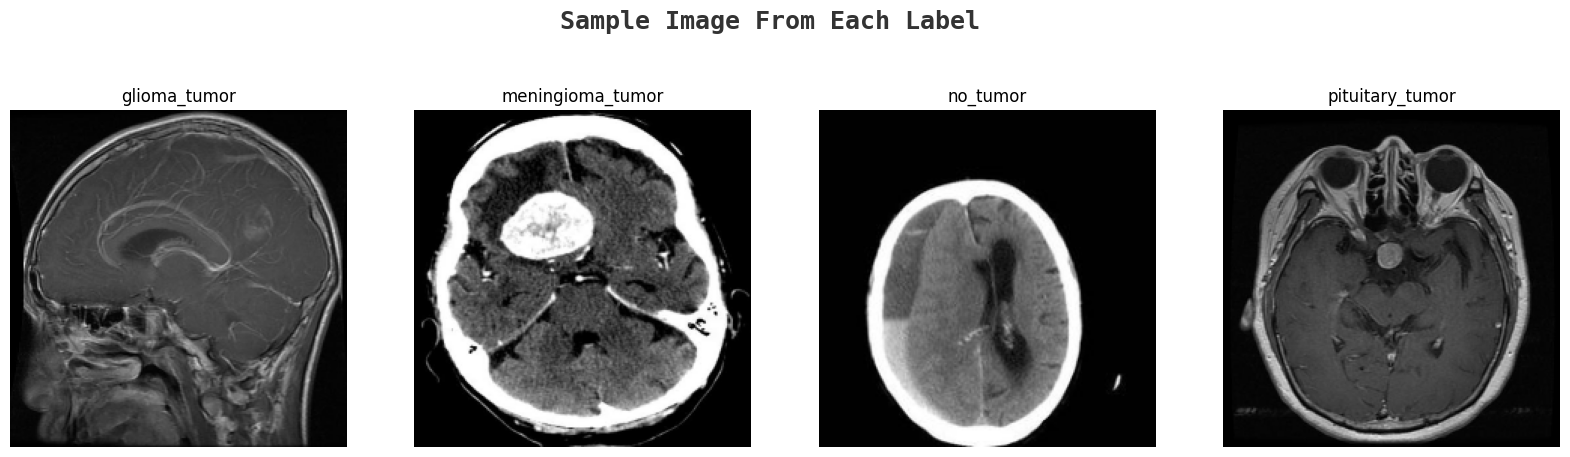

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [6]:
X_train.shape

(974, 224, 224, 3)

In [7]:
X_test.shape

(338, 224, 224, 3)

<Axes: ylabel='count'>

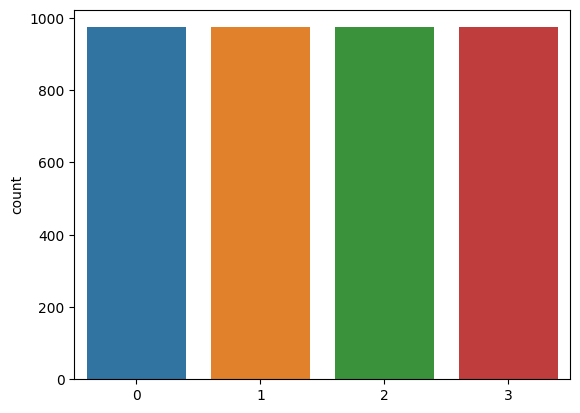

In [10]:
sns.countplot(y_train)

<Axes: ylabel='count'>

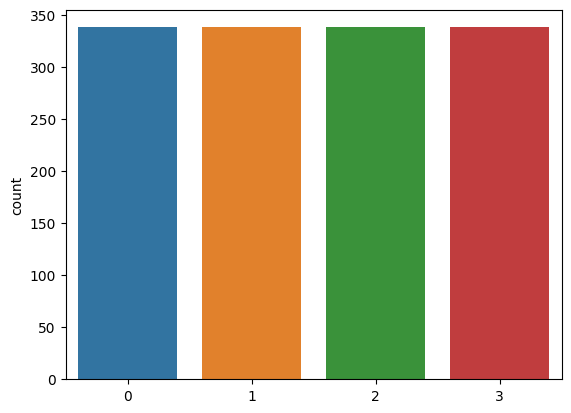

In [9]:
sns.countplot(y_test)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [12]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [15]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (5, 5), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(512))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      4864      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 128)     73856     
                                                                 
 activation_2 (Activation)   (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0

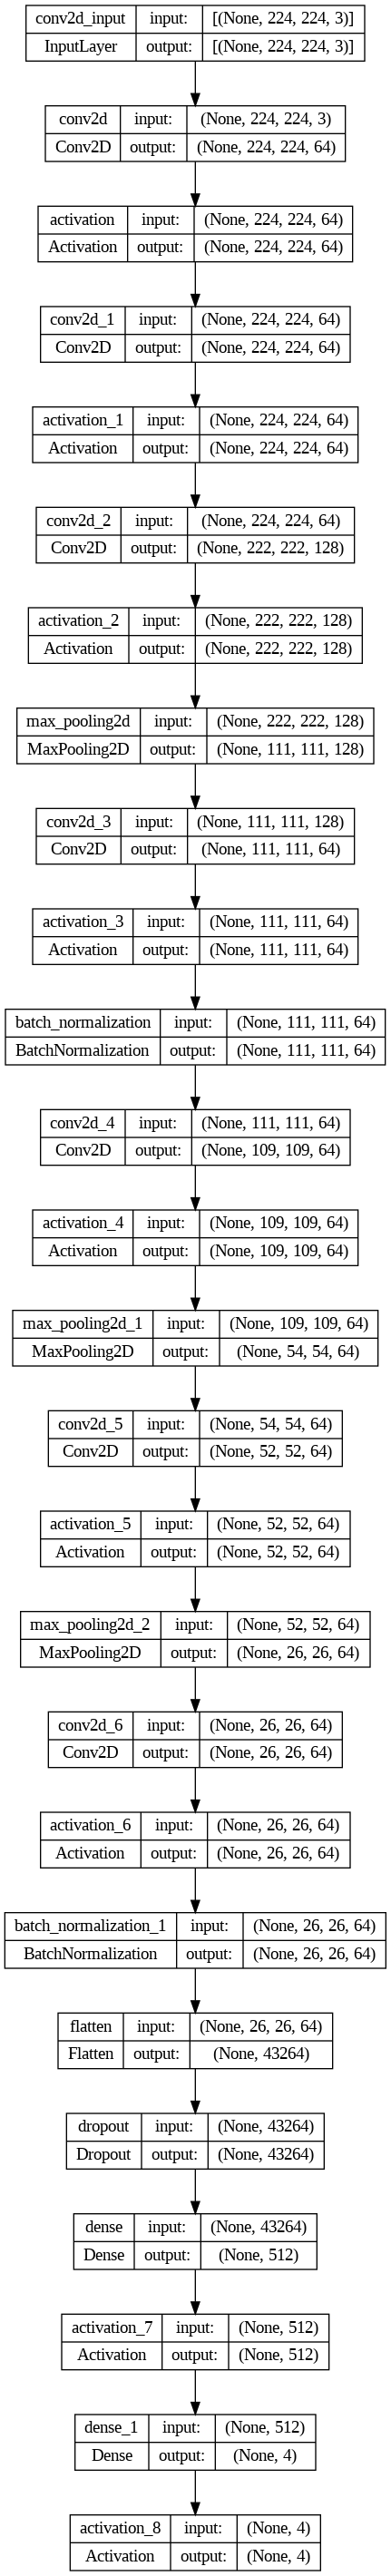

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [18]:
history = model_cnn.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)

Epoch 1/15
28/28 [==============================] - 40s 537ms/step - loss: 3.5987 - accuracy: 0.5719 - val_loss: 1.7238 - val_accuracy: 0.4082
Epoch 2/15
28/28 [==============================] - 10s 351ms/step - loss: 0.6573 - accuracy: 0.7751 - val_loss: 1.2458 - val_accuracy: 0.4898
Epoch 3/15
28/28 [==============================] - 10s 354ms/step - loss: 0.3542 - accuracy: 0.8801 - val_loss: 1.0200 - val_accuracy: 0.5510
Epoch 4/15
28/28 [==============================] - 10s 356ms/step - loss: 0.2037 - accuracy: 0.9326 - val_loss: 0.7328 - val_accuracy: 0.6837
Epoch 5/15
28/28 [==============================] - 10s 361ms/step - loss: 0.1191 - accuracy: 0.9578 - val_loss: 0.4860 - val_accuracy: 0.8469
Epoch 6/15
28/28 [==============================] - 10s 365ms/step - loss: 0.0753 - accuracy: 0.9840 - val_loss: 0.3780 - val_accuracy: 0.8571
Epoch 7/15
28/28 [==============================] - 10s 369ms/step - loss: 0.0823 - accuracy: 0.9715 - val_loss: 0.5043 - val_accuracy: 0.8265

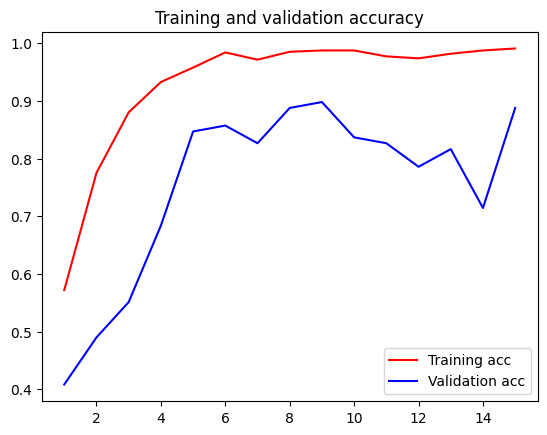

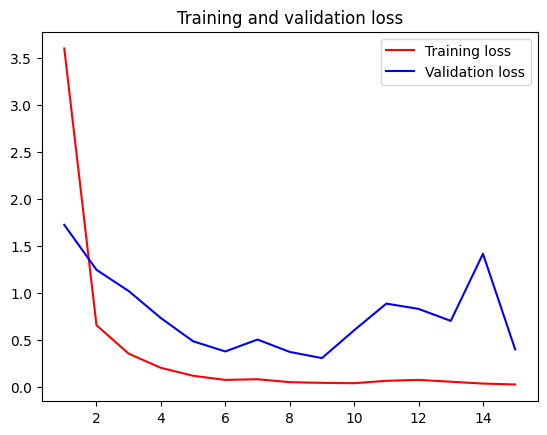

In [19]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 4s 338ms/step


In [21]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 71.60%


In [22]:
model_cnn.evaluate(X_train, y_train)

28/28 [==============================] - 3s 97ms/step - loss: 0.0505 - accuracy: 0.9795


[0.0504668764770031, 0.9794520735740662]

In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.85      0.23      0.36        75
           1       0.59      0.98      0.73       100
           2       0.82      0.92      0.87       105
           3       0.94      0.52      0.67        58

    accuracy                           0.72       338
   macro avg       0.80      0.66      0.66       338
weighted avg       0.78      0.72      0.68       338



In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
VGG16

In [24]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
for layers in vgg.layers:
  layers.trainable=False

In [26]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

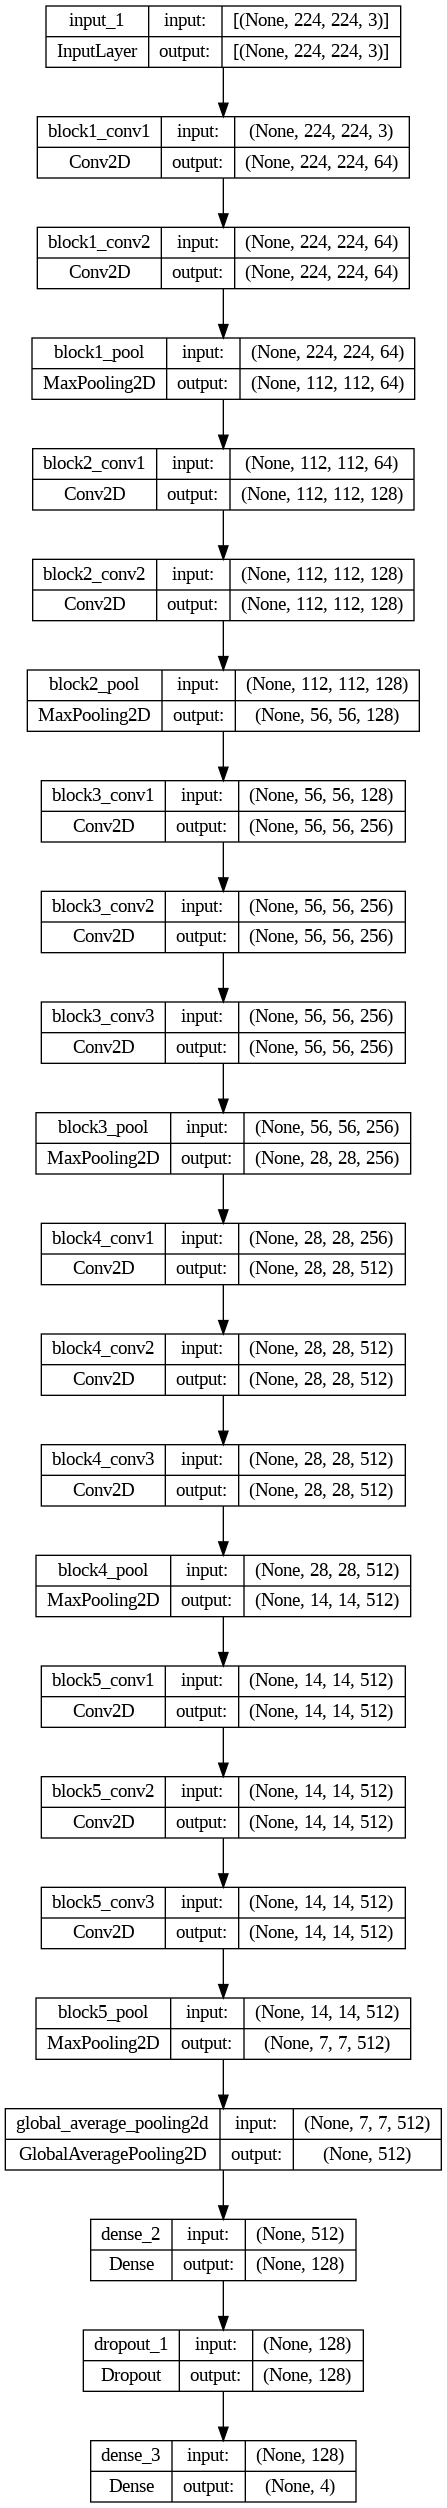

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [29]:
history = model_vgg.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)
                  #callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
28/28 [==============================] - 13s 268ms/step - loss: 1.3278 - accuracy: 0.3927 - val_loss: 1.1261 - val_accuracy: 0.6837
Epoch 2/15
28/28 [==============================] - 4s 151ms/step - loss: 1.0788 - accuracy: 0.5811 - val_loss: 0.9643 - val_accuracy: 0.6633
Epoch 3/15
28/28 [==============================] - 5s 165ms/step - loss: 0.9431 - accuracy: 0.6689 - val_loss: 0.8628 - val_accuracy: 0.7857
Epoch 4/15
28/28 [==============================] - 5s 163ms/step - loss: 0.8259 - accuracy: 0.7237 - val_loss: 0.7552 - val_accuracy: 0.7551
Epoch 5/15
28/28 [==============================] - 4s 150ms/step - loss: 0.7318 - accuracy: 0.7568 - val_loss: 0.7253 - val_accuracy: 0.7755
Epoch 6/15
28/28 [==============================] - 4s 159ms/step - loss: 0.6979 - accuracy: 0.7728 - val_loss: 0.6745 - val_accuracy: 0.7551
Epoch 7/15
28/28 [==============================] - 4s 160ms/step - loss: 0.6459 - accuracy: 0.7774 - val_loss: 0.6494 - val_accuracy: 0.8469
Epoch

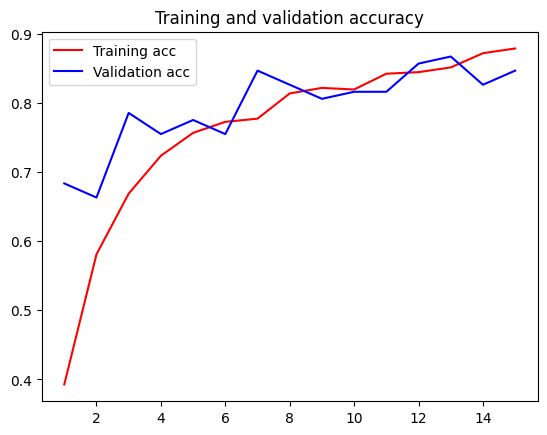

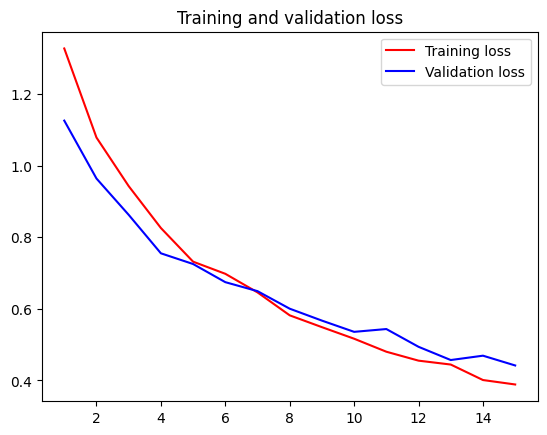

In [30]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 4s 349ms/step


In [32]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 61.83%


In [33]:
model_vgg.evaluate(X_train, y_train)

28/28 [==============================] - 4s 124ms/step - loss: 0.3504 - accuracy: 0.8927


[0.35043254494667053, 0.8926940560340881]

In [34]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.55      0.21      0.31        75
           1       0.62      0.66      0.64       100
           2       0.59      0.85      0.69       105
           3       0.76      0.66      0.70        58

    accuracy                           0.62       338
   macro avg       0.63      0.59      0.59       338
weighted avg       0.62      0.62      0.59       338



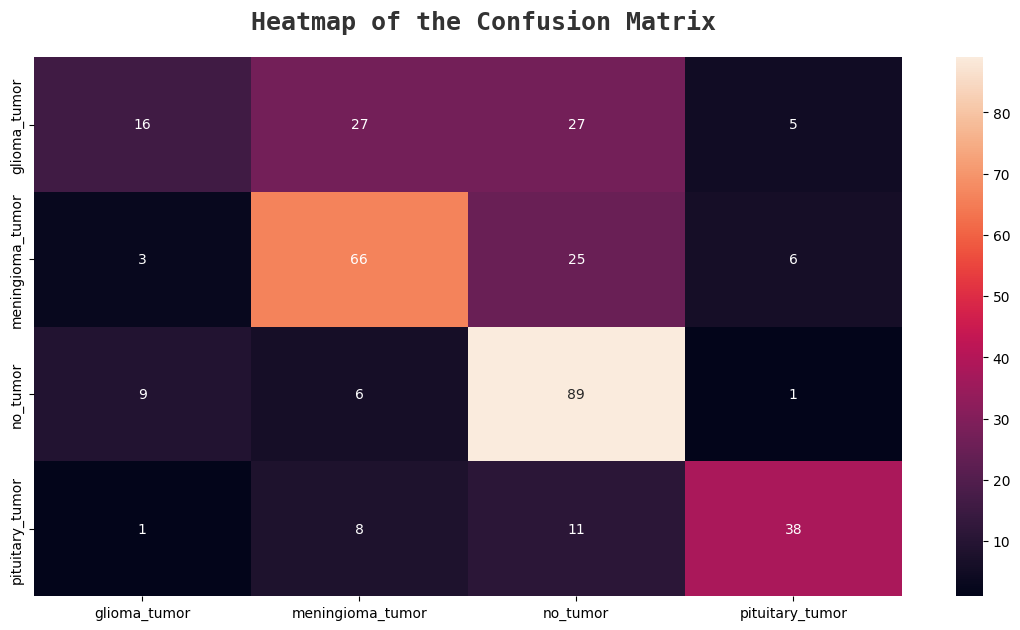

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
EfficientNetB0

In [80]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [81]:
model_eff = effnet.output
model_eff = tf.keras.layers.GlobalAveragePooling2D()(model_eff)
model_eff = tf.keras.layers.Dropout(rate=0.5)(model_eff)
model_eff = tf.keras.layers.Dense(100,activation='relu')(model_eff)
model_eff = tf.keras.layers.Dense(4,activation='softmax')(model_eff)
model_eff = tf.keras.models.Model(inputs=effnet.input, outputs = model_eff)
model_eff.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

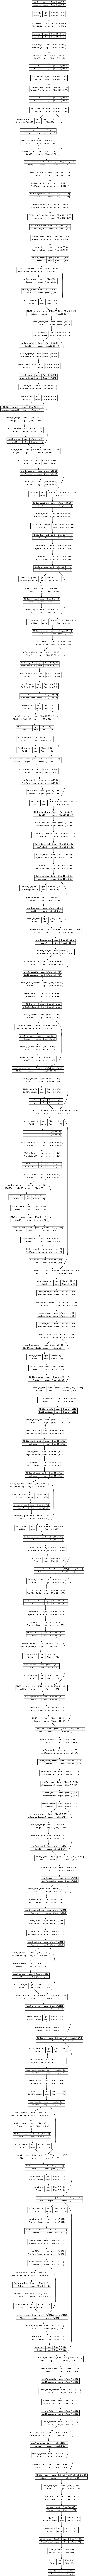

In [82]:
from keras.utils.vis_utils import plot_model
plot_model(model_eff, to_file='model_eff_plot.png', show_shapes=True, show_layer_names=True)

In [83]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [84]:
history = model_eff.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)
#, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
28/28 [==============================] - 58s 420ms/step - loss: 0.5175 - accuracy: 0.7991 - val_loss: 1.5551 - val_accuracy: 0.1837
Epoch 2/15
28/28 [==============================] - 8s 271ms/step - loss: 0.2002 - accuracy: 0.9326 - val_loss: 1.6763 - val_accuracy: 0.1633
Epoch 3/15
28/28 [==============================] - 7s 265ms/step - loss: 0.1178 - accuracy: 0.9635 - val_loss: 1.7492 - val_accuracy: 0.1633
Epoch 4/15
28/28 [==============================] - 8s 280ms/step - loss: 0.1412 - accuracy: 0.9612 - val_loss: 1.5920 - val_accuracy: 0.1735
Epoch 5/15
28/28 [==============================] - 7s 261ms/step - loss: 0.1178 - accuracy: 0.9589 - val_loss: 1.9188 - val_accuracy: 0.1837
Epoch 6/15
28/28 [==============================] - 7s 265ms/step - loss: 0.0344 - accuracy: 0.9886 - val_loss: 1.6407 - val_accuracy: 0.1531
Epoch 7/15
28/28 [==============================] - 8s 270ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 1.8473 - val_accuracy: 0.2245
Epoch

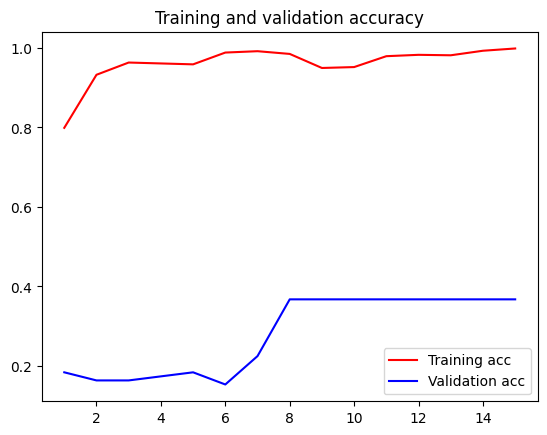

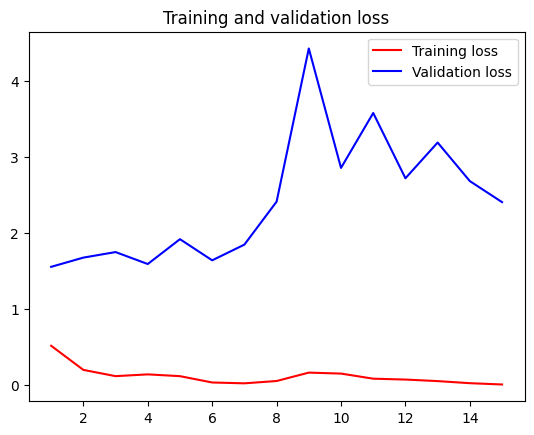

In [95]:
model_cnn.save('eff_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [96]:
pred = model_eff.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 68ms/step


In [97]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 31.07%


In [98]:
model_eff.evaluate(X_train, y_train)

28/28 [==============================] - 2s 61ms/step - loss: 2.5263 - accuracy: 0.3185


[2.5263113975524902, 0.31849315762519836]

In [99]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00       100
           2       0.31      1.00      0.47       105
           3       0.00      0.00      0.00        58

    accuracy                           0.31       338
   macro avg       0.08      0.25      0.12       338
weighted avg       0.10      0.31      0.15       338



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

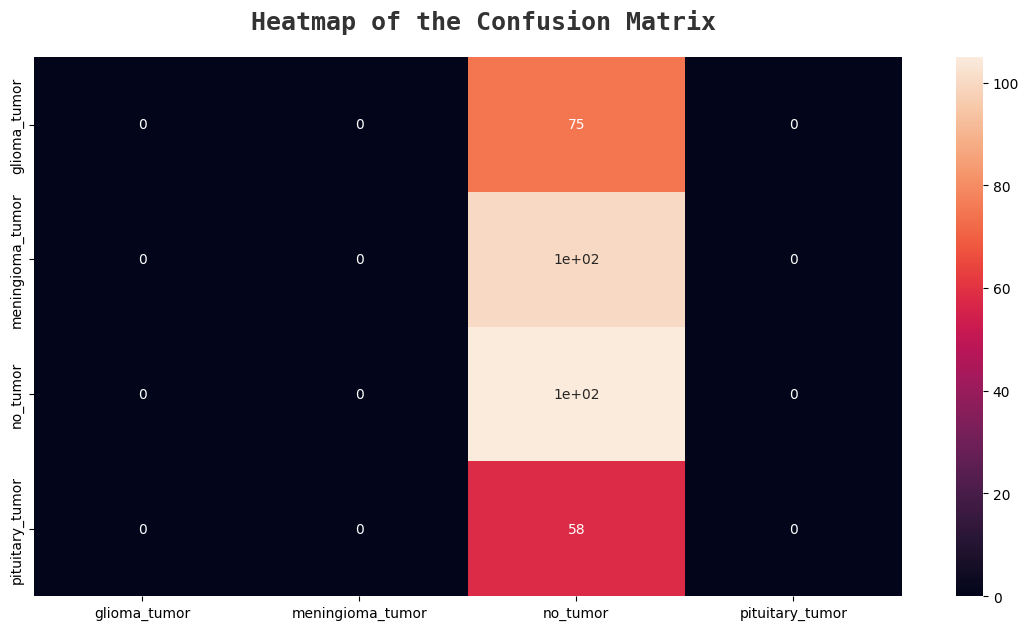

In [100]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

In [101]:
model_cnn = Sequential()

model_cnn.add(Conv2D(128, (5, 5), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(128, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(512))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 128)     9728      
                                                                 
 activation_27 (Activation)  (None, 224, 224, 128)     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 64)      73792     
                                                                 
 activation_28 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 222, 222, 128)     73856     
                                                                 
 activation_29 (Activation)  (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 128)   

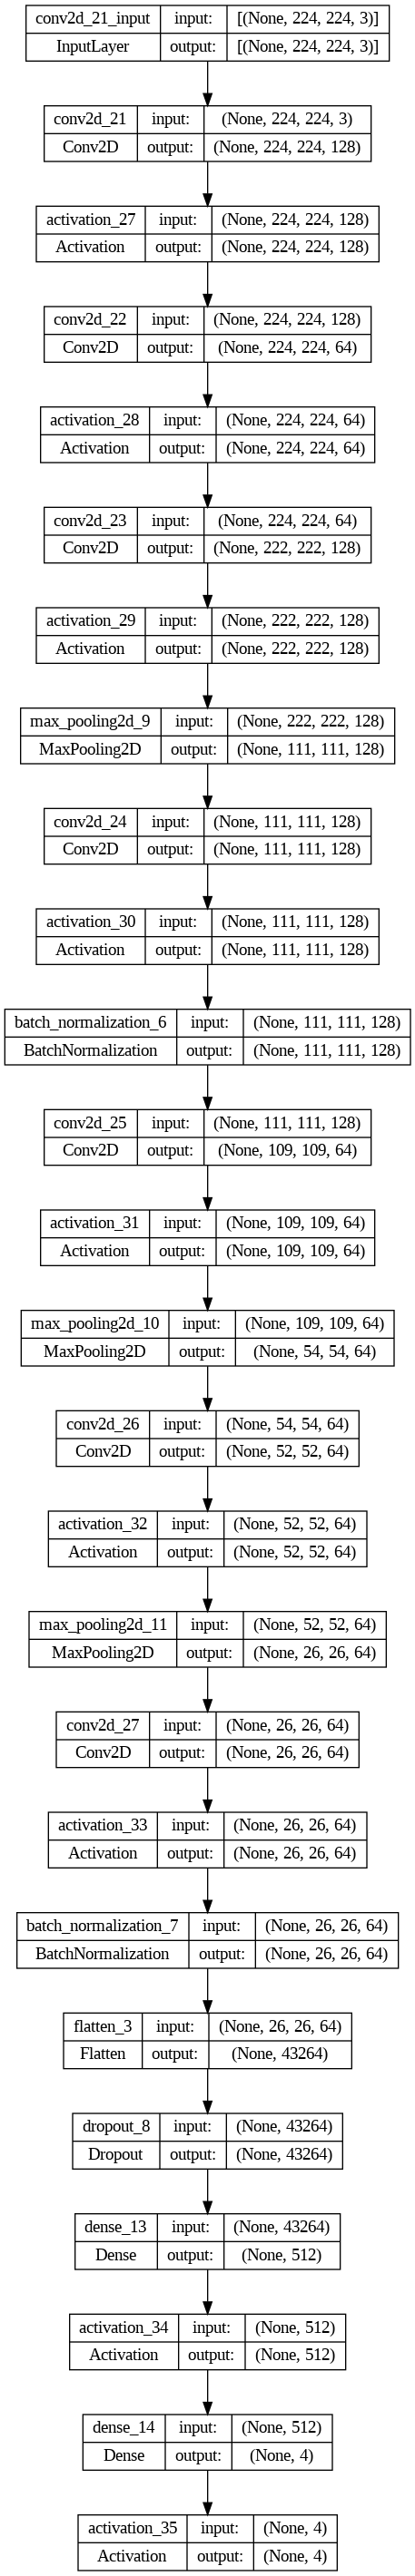

In [102]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [103]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [111]:
history = model_cnn.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 64, validation_data = (X_val, y_val),
                     epochs = 20)
                #callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
14/14 [==============================] - 15s 1s/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.6139 - val_accuracy: 0.8469
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.4602 - val_accuracy: 0.8980
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 0.0789 - accuracy: 0.9943 - val_loss: 5.4541 - val_accuracy: 0.4286
Epoch 4/20
14/14 [==============================] - 15s 1s/step - loss: 0.0512 - accuracy: 0.9840 - val_loss: 1.7121 - val_accuracy: 0.6837
Epoch 5/20
14/14 [==============================] - 14s 1s/step - loss: 0.0498 - accuracy: 0.9829 - val_loss: 2.3100 - val_accuracy: 0.6837
Epoch 6/20
14/14 [==============================] - 14s 1s/step - loss: 0.0592 - accuracy: 0.9817 - val_loss: 0.4777 - val_accuracy: 0.8980
Epoch 7/20
14/14 [==============================] - 14s 1s/step - loss: 0.0202 - accuracy: 0.9954 - val_loss: 0.9299 - val_accuracy: 0.7551
Epoch 8/20
14/14 [==

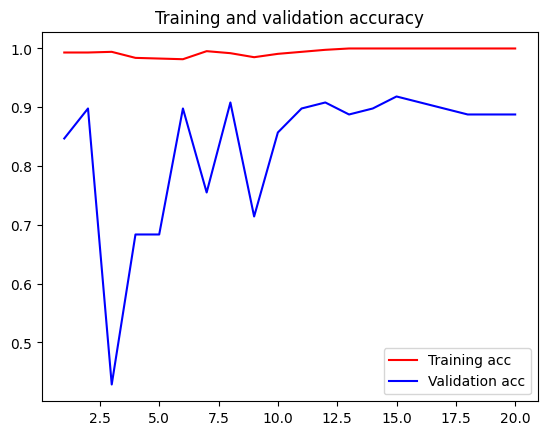

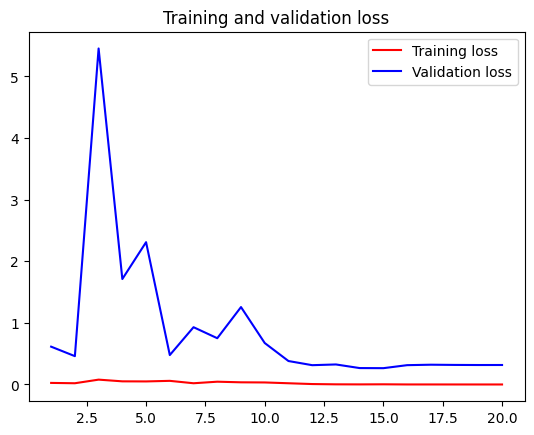

In [112]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 125ms/step


In [114]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 72.19%


In [115]:
model_cnn.evaluate(X_train, y_train)

28/28 [==============================] - 4s 127ms/step - loss: 1.7179e-04 - accuracy: 1.0000


[0.00017179192218463868, 1.0]

In [116]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.82      0.19      0.30        75
           1       0.68      0.97      0.80       100
           2       0.71      0.97      0.82       105
           3       0.91      0.53      0.67        58

    accuracy                           0.72       338
   macro avg       0.78      0.67      0.65       338
weighted avg       0.76      0.72      0.67       338



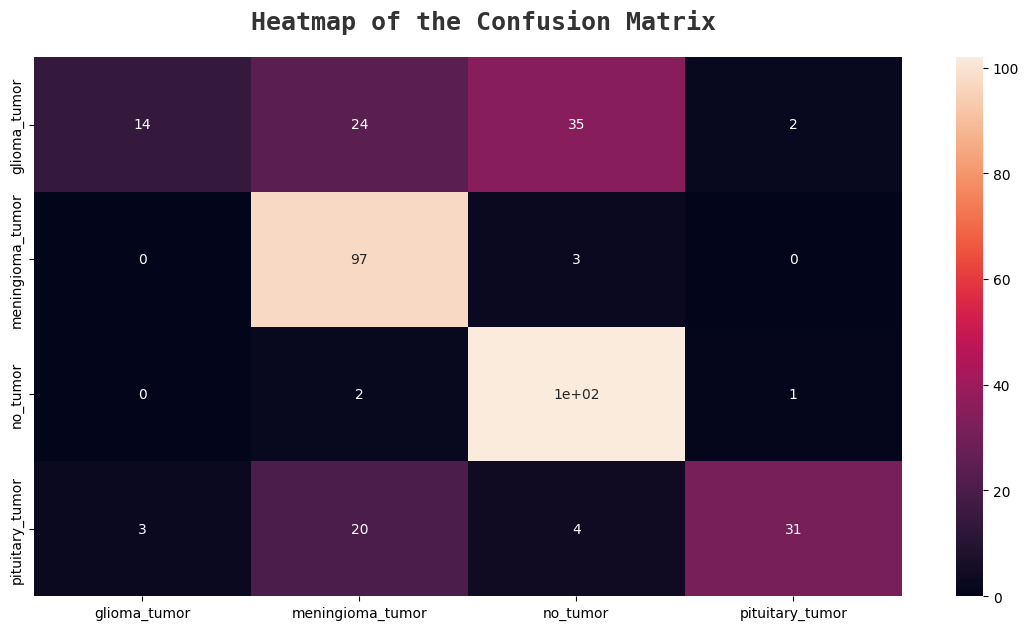

In [117]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

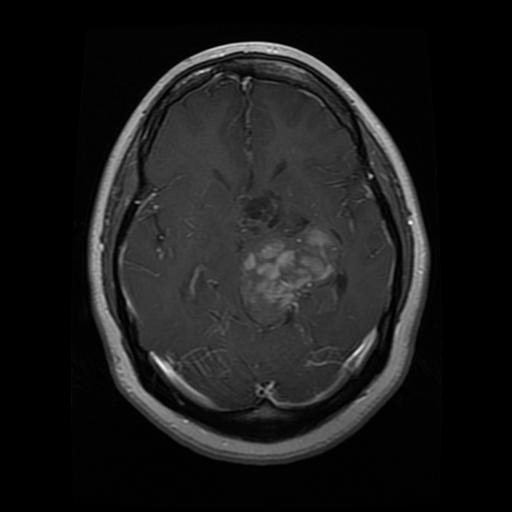

In [118]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../content/drive/MyDrive/new first objective dataset/Training/glioma_tumor/gg (1).jpg"

display(Image(img_path))

In [119]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01930112', 'nematode', 11.258018)]


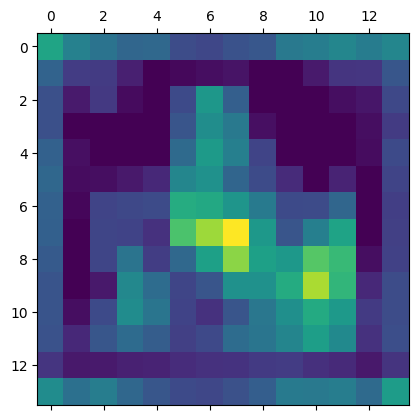

In [120]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-121-09cf26cf315d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


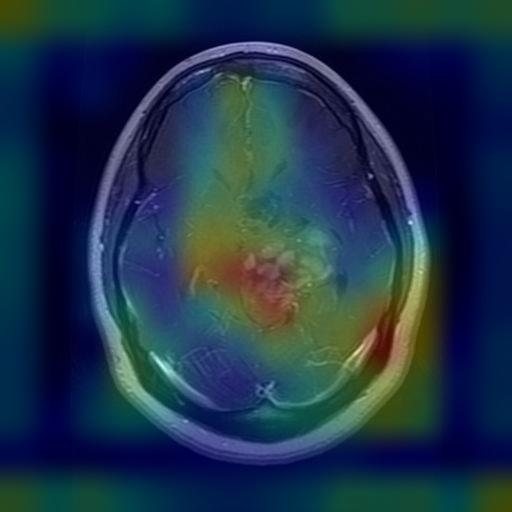

In [121]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



save_and_display_gradcam(img_path, heatmap)

In [122]:
model_builder = tf.keras.applications.efficientnet.EfficientNetB0
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"

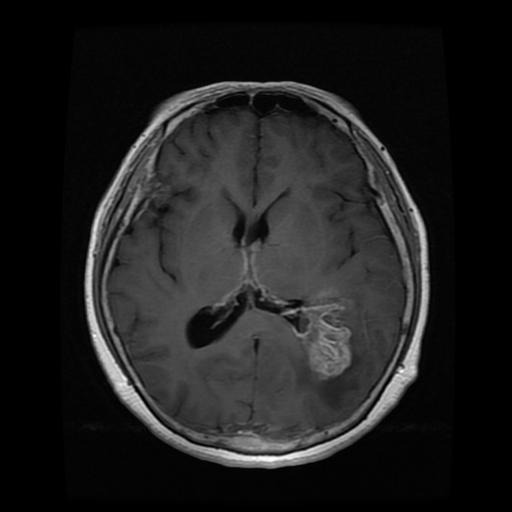

1/1 [==============================] - 2s 2s/step
Predicted: [('n03920288', 'Petri_dish', 7.5967464)]


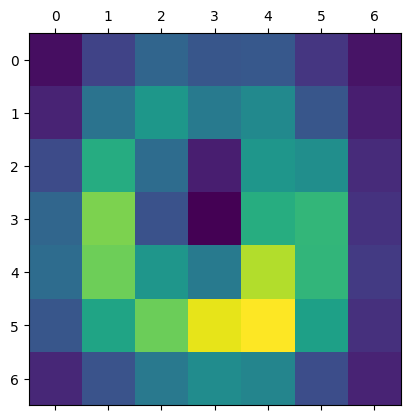

<ipython-input-121-09cf26cf315d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


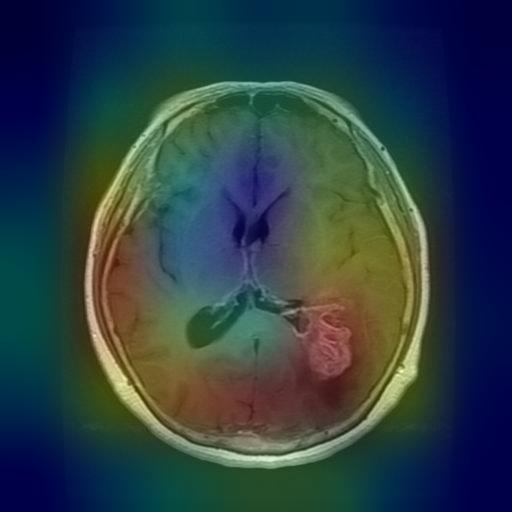

In [123]:
img_path ="../content/drive/MyDrive/new first objective dataset/Training/glioma_tumor/gg (10).jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

In [ ]:
Experimental results

In [124]:
# Function to convert output labels to its class of tumor.
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

In [ ]:
Prediction using CNN model

In [127]:
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

28/28 [==============================] - 4s 118ms/step
Accuracy on training set: 100.00%


In [128]:
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

11/11 [==============================] - 1s 127ms/step
Accuracy on testing set: 72.19%


1/1 [==============================] - 0s 27ms/step


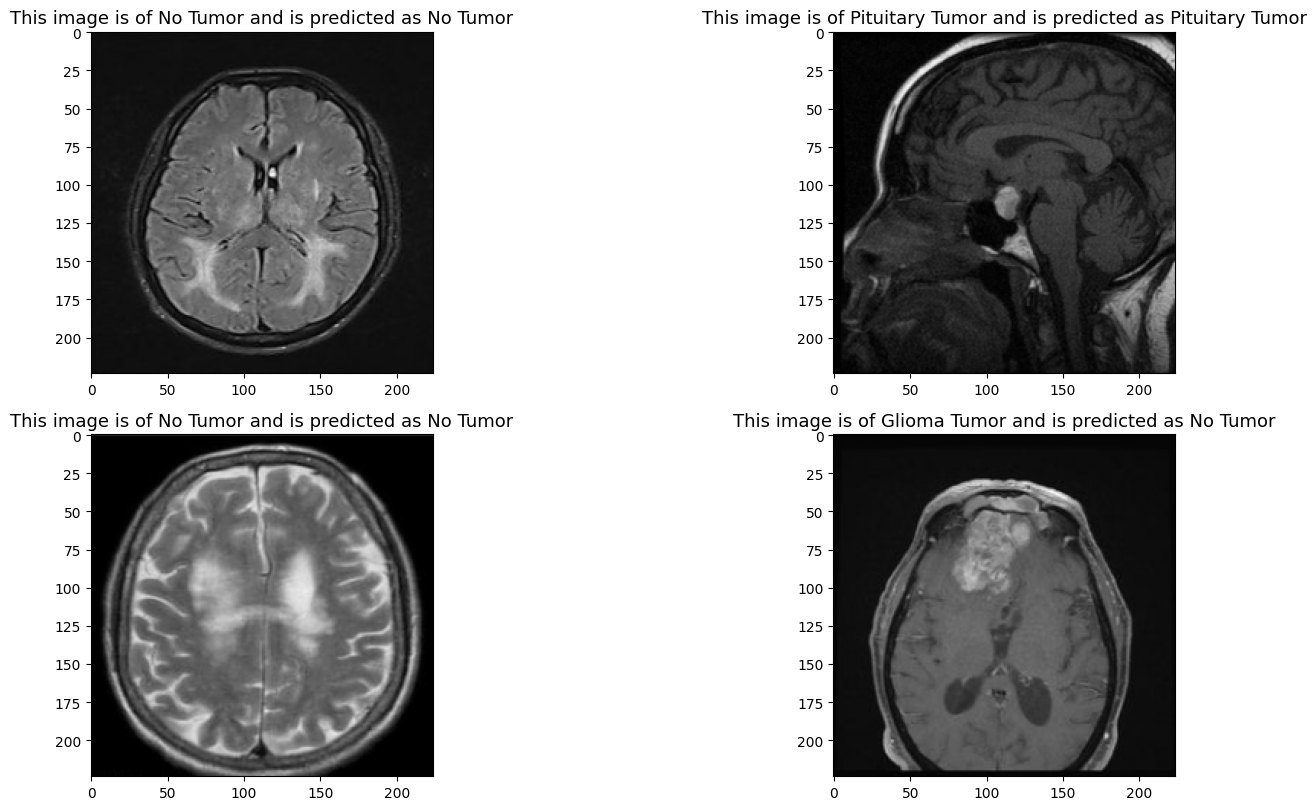

In [137]:
# Prediction using CNN model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

In [ ]:
Prediction using VGG16 model

In [130]:
train_pred = model_vgg.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

28/28 [==============================] - 3s 123ms/step
Accuracy on training set: 89.27%


In [131]:
test_pred = model_vgg.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

11/11 [==============================] - 1s 126ms/step
Accuracy on testing set: 61.83%


1/1 [==============================] - 0s 24ms/step


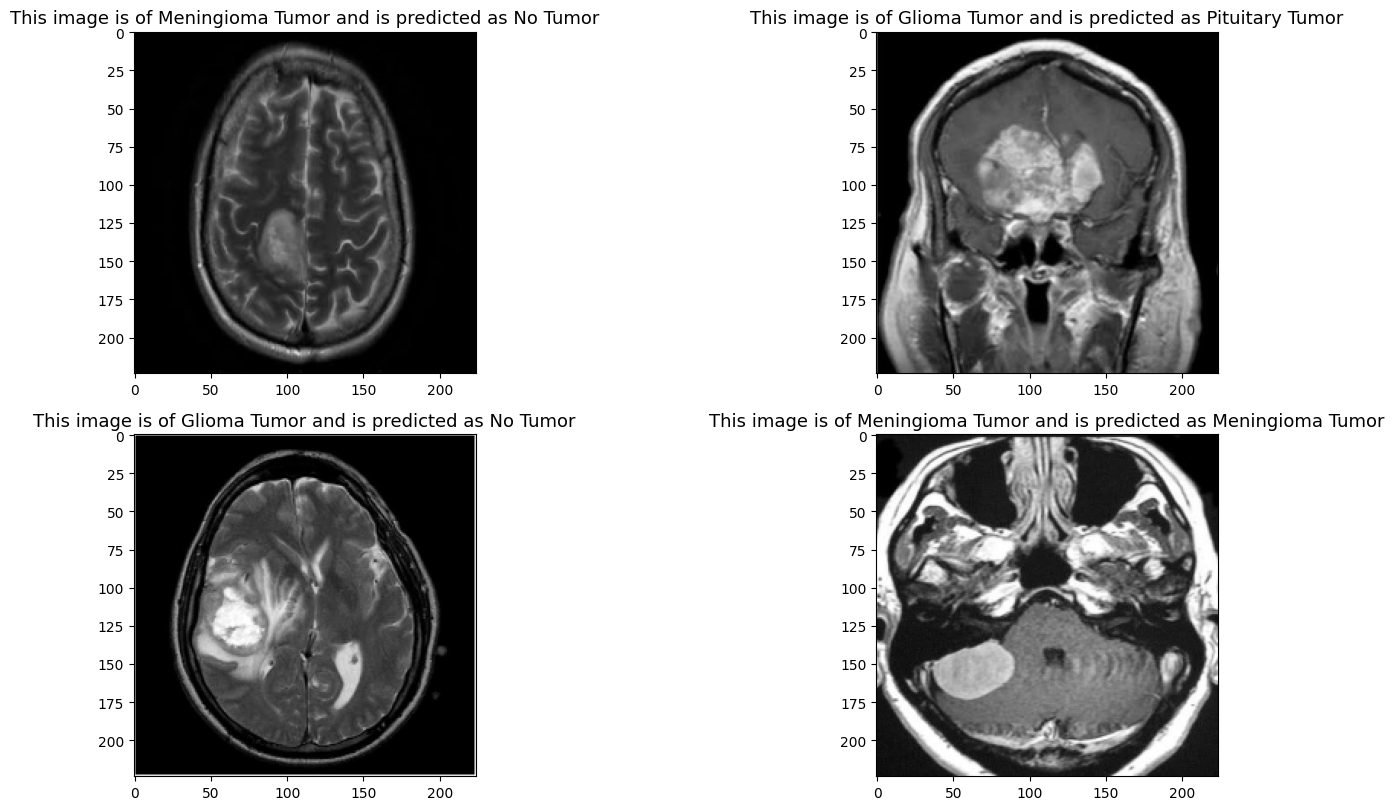

In [136]:
# Prediction using VGG16 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_vgg.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

In [ ]:
Prediction using EfficientNetB0

In [133]:
train_pred = model_eff.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

28/28 [==============================] - 2s 58ms/step
Accuracy on training set: 31.85%


In [134]:
test_pred = model_eff.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

11/11 [==============================] - 1s 61ms/step
Accuracy on testing set: 31.07%


1/1 [==============================] - 0s 29ms/step


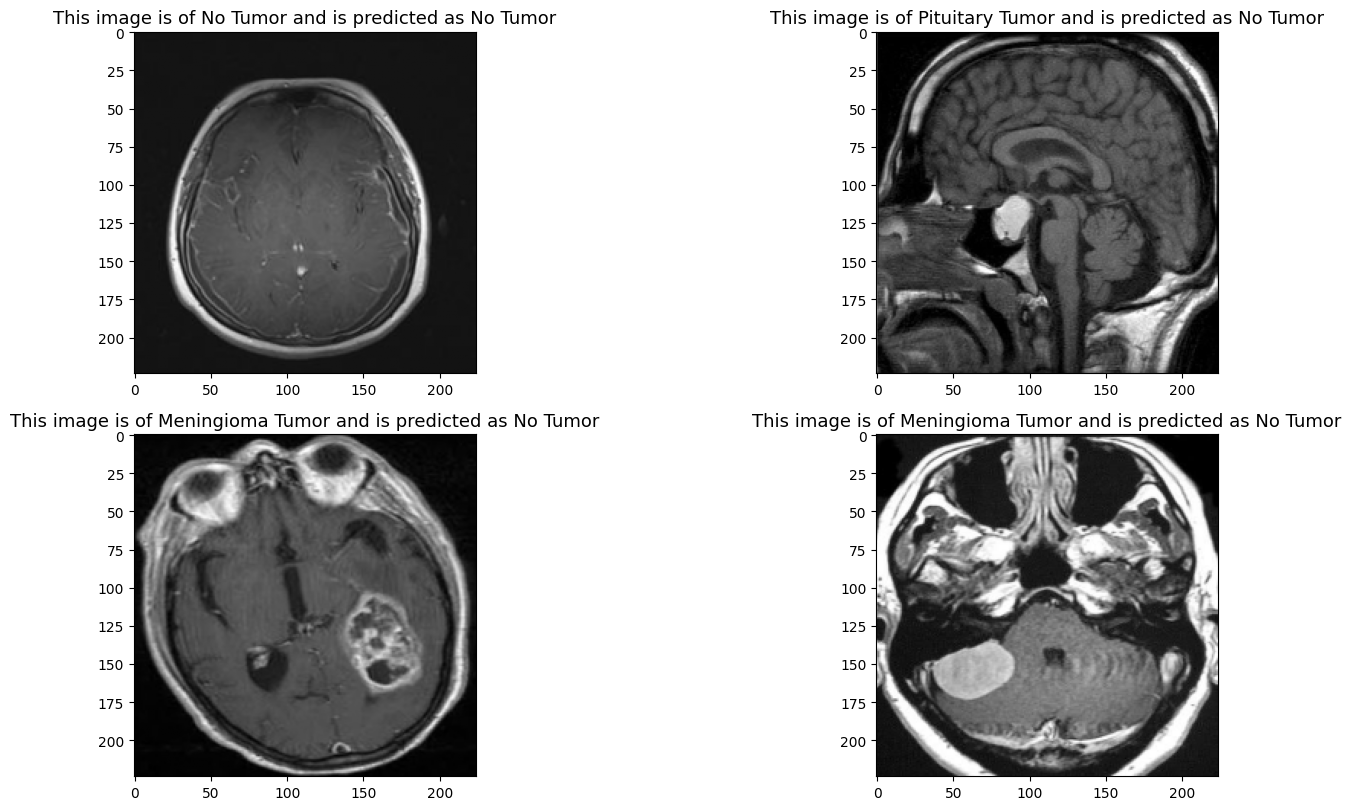

In [135]:
# Prediction using EfficientNetB0 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_eff.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()